In [2]:
# Import functions 
import sys
sys.path.insert(0, '..')
from racecar_utils import *   

In [3]:
# Start ROS Node
rospy.init_node('racecar')
rc = Racecar()
print('ROS node started successfully')

ROS node started successfully


# Sign detection functions

In [24]:
nFeatures = 500

MATCH_TYPE = False            # True: use match count, False: use match percentage
MIN_MATCH_COUNT = 10          # minimum number of matches required for an object to be considered a "detected"
MIN_MATCH_PERCENTAGE = 0.02   # minimum match percentage required for an object to be considered a "detected"

In [39]:
# Sign detection functions

def get_keypoints(image):
    '''
    outputs keypoints and descriptions for the inputted image.
    '''
    orb = cv2.ORB_create(nFeatures)
    kp, des = orb.detectAndCompute(image, None)
    return kp, des

def calculate_matches(des_q, des_f):
    # FLANN parameters
    FLANN_INDEX_LSH = 6
    index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1)
    search_params = None

    # Matching keypoints
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    if (des_q is not None) and (des_f is not None) and des_f.shape[0] > 10:
        matches = flann.knnMatch(des_q, des_f, k=2)
    else:
        matches = []

    # store good matches via Lowe's ratio test
    good_matches = []
    for m_n in matches:
        if len(m_n) != 2:
            continue
        (m,n) = m_n
        if m.distance < 0.6*n.distance:
            good_matches.append(m)

    total_matches = len(des_q) * 1.0
    match_percentage = len(good_matches)/total_matches
    print ("# Matches: {}, Match Percentage: {}".format(len(good_matches), match_percentage))
    
    detected = False

    # Checking if object is detected
    if MATCH_TYPE:
        if len(good_matches) > MIN_MATCH_COUNT:
            detected = True
        else:
            detected = False
    else:
        if match_percentage > MIN_MATCH_PERCENTAGE:
            detected = True
        else:
            detected = False
    return detected, good_matches


def detect_sign(frame, kp_q, des_q):
    '''
    Input a frame and function will output a boolean. True = sign detected and False = not detected.

    (Np.ndarray) frame
    (STRING) feature_detection_algorithm = 'sift', 'surf', 'orb'.
    (INT) hessianThreshold is basically number of key points. Smaller = more keypoints.
    (INT) MIN_MATCH_COUNT is the minimum number of good matches for an object to be considered the query image.
    (FLOAT) MIN_MATCH_PERCENTAGE is the minimum match percentage for an object to be considered the query image.
    (BOOL) MIN_MATCH is a boolean. True means sign detectoin will use MIN_MATCH_COUNT. False means sign detection will use MIN_MATCH_PERCENTAGE.
    '''
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    if (des_q is None):
        detected = False
        kp_q, kp_f = 0, 0
        good_matches = []
        return detected, kp_q, kp_f, good_matches

    # Create ORB object
    kp_f, des_f = get_keypoints(frame)

    # Calculate good matches
    detected, good_matches = calculate_matches(des_q, des_f)
    
    return detected, kp_q, kp_f, good_matches


# Show simple image first to prevent camera errors

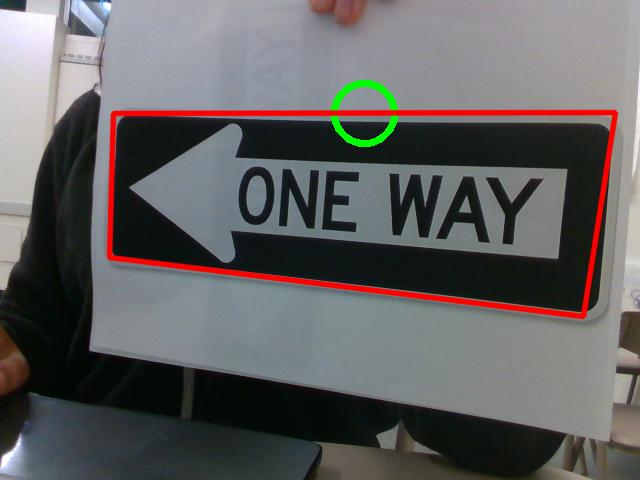

In [6]:
#draws rectangle over frame to crop
def simple_show(img):
    return img

show_image(simple_show)

# Sign detection without moving the car

In [7]:
DEBUG = True
TEST_TIME = 10

In [40]:
queryImage = cv2.imread('one_way.jpg')
kp_q, des_q = get_keypoints(queryImage)
query_columns = 0

# setup display
display = IPython.display.display('', display_id=current_display_id)
current_display_id += 1

def detect_sign_live(frame):
    detected, keypoint_query, keypoint_frame, good_matches = detect_sign(frame, kp_q, des_q)
    frame, dst, x_center, y_center = find_object(frame, queryImage, detected, keypoint_query, keypoint_frame, good_matches, query_columns)
    
    if DEBUG:
        cv2.circle(frame, (x_center, y_center), 30, (0, 255, 0), 5)
        cv2.polylines(frame,[np.int32(dst)], True, (0, 0, 255), 3, cv2.LINE_AA)
        show_frame(frame)

rc.run(detect_sign_live, TEST_TIME)



''

# Matches: 1, Match Percentage: 0.00275482093664
# Matches: 39, Match Percentage: 0.107438016529
# Matches: 35, Match Percentage: 0.0964187327824
# Matches: 32, Match Percentage: 0.0881542699725
# Matches: 30, Match Percentage: 0.0826446280992
# Matches: 33, Match Percentage: 0.0909090909091
# Matches: 33, Match Percentage: 0.0909090909091
# Matches: 36, Match Percentage: 0.099173553719
# Matches: 28, Match Percentage: 0.0771349862259
# Matches: 40, Match Percentage: 0.110192837466
# Matches: 30, Match Percentage: 0.0826446280992
# Matches: 34, Match Percentage: 0.0936639118457
# Matches: 33, Match Percentage: 0.0909090909091
# Matches: 25, Match Percentage: 0.068870523416
# Matches: 19, Match Percentage: 0.0523415977961
# Matches: 25, Match Percentage: 0.068870523416
# Matches: 27, Match Percentage: 0.0743801652893
# Matches: 30, Match Percentage: 0.0826446280992
# Matches: 31, Match Percentage: 0.0853994490358
# Matches: 30, Match Percentage: 0.0826446280992
# Matches: 32, Match Perc

# Getting Angle

In [56]:
TURN_FACTOR = 30          # max turn angle (in degrees)
DRIVE_SPEED = 0.215       # car speed      

In [57]:
def get_angle(contour_center):
    max_angle = -abs(TURN_FACTOR) 
    
    # TASK #1: Calculate the offset error
    error = contour_center - float(SCREEN_CENTER)

    # TASK #2: Calculate the ratio
    ratio = error/SCREEN_CENTER

    # TASK #3: Calculate the turn angle
    angle = ratio*max_angle 

    # TASK #4: Return the turn angle
    return angle

# Screen Offset

In [75]:
SCREEN_CENTER = 395.0     # pixel x-axis, camera is right-shifted

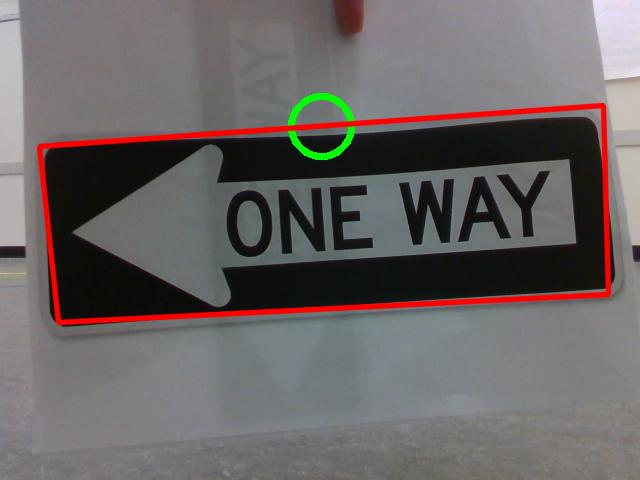

In [76]:
# mark location of SCREEN_CENTER (x-axis)
def identify_center(img):
    if SCREEN_CENTER < 0 or SCREEN_CENTER > img.shape[1]:
        print('SCREEN_CENTER out of bounds! Your image is: {}'.format(img.shape[:2]))
    cv2.circle(img, (int(SCREEN_CENTER), img.shape[0]/2), 5, (0,255,0), 3)
    return img

# display image
show_image(identify_center)

# Following the Sign

In [77]:
DEBUG = True
TEST_TIME = 10

In [78]:
# Reading in image
queryImage = cv2.imread('one_way.jpg')
queryColumns = 0

kp_q, des_q = get_keypoints(queryImage)

def follow_sign(frame):
    detected, keypoint_query, keypoint_frame, good_matches = detect_sign(frame, kp_q, des_q)
    frame, dst, x_center, y_center = find_object(frame, queryImage, detected, keypoint_query, keypoint_frame, good_matches, queryColumns)
    
    speed = 0
    angle = 0
    if detected:
        speed = DRIVE_SPEED
        angle = get_angle(x_center)
        
    if DEBUG:
        cv2.circle(frame, (x_center, y_center), 30, (0, 255, 0), 5)
        cv2.polylines(frame,[np.int32(dst)], True, (0, 0, 255), 3, cv2.LINE_AA)
        show_frame(frame)
    
    rc.drive(speed, angle)

rc.run(follow_sign, TEST_TIME)


Match Percentage: 0%
Match Percentage: 7.71%
Match Percentage: 9.09%
Match Percentage: 9.64%
Match Percentage: 7.71%
Match Percentage: 9.09%
Match Percentage: 7.16%
Match Percentage: 9.09%
Match Percentage: 7.99%
Match Percentage: 7.71%
Match Percentage: 5.23%
Match Percentage: 8.54%
Match Percentage: 7.99%
Match Percentage: 8.26%
Match Percentage: 9.64%
Match Percentage: 7.44%
Match Percentage: 8.26%
Match Percentage: 7.71%
Match Percentage: 11.6%
Match Percentage: 8.54%
Match Percentage: 8.26%
Match Percentage: 7.16%
Match Percentage: 6.89%
Match Percentage: 7.44%
Match Percentage: 5.23%
Match Percentage: 4.96%
Match Percentage: 7.71%
Match Percentage: 8.54%
Match Percentage: 7.71%
Match Percentage: 8.82%
Match Percentage: 7.71%
Match Percentage: 5.79%
Match Percentage: 7.44%
Match Percentage: 6.61%
Match Percentage: 7.16%
Match Percentage: 6.34%
Match Percentage: 5.51%
Match Percentage: 6.34%
Match Percentage: 6.89%
Match Percentage: 7.99%
Match Percentage: 6.89%
Match Percentage: 5